# Fleet assignment problem

## Problem description

Given a set of flights to be flown, an airline company needs to determine the specific route flown by each airplane in the most cost-effective way. Clearly, the airline company should try to use as fewer airplanes as possible, but the same airplane can operate two subsequent flights only if the time interval between the arrival of the first flight and the departure of the next flight is longer than or equal to one hour.

The task of the airline operations team is to determine the minimum number of airplanes needed to operate the given list of flights. This problem is known as the **fleet assignment problem** or **aircraft rotation problem**.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Generate Flight Data

In [11]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from numpy.random import RandomState

# python generator creates departure and arrival times for a single airport
def generate_flights(N_flights=30, min_duration=1, max_duration=4, max_departure=24, seed=0):
    rs = RandomState(seed)
    for flight in range(N_flights):
        end_flight = max_departure + 1
        while end_flight > max_departure:
            start_flight = np.floor(max_departure * rs.rand())
            end_flight = start_flight + 3 * np.ceil((max_duration + 1 - min_duration) * rs.rand()) 
        yield flight + 1, int(start_flight), int(end_flight)

# generate flight data
FlightData = pd.DataFrame([[flight, departure, arrival] for flight, departure, arrival in generate_flights()])
FlightData.columns = ["Flight", "Departure", "Arrival"]
FlightData.set_index("Flight", inplace=True)
FlightData.head()

,Departure,Arrival
Flight,,
1,13,22
2,14,23
3,10,19
4,10,22
5,1,4


## Visualize Flight Data

<AxesSubplot:title={'center':'FlightData'}, xlabel='Departure/Arrival Time'>

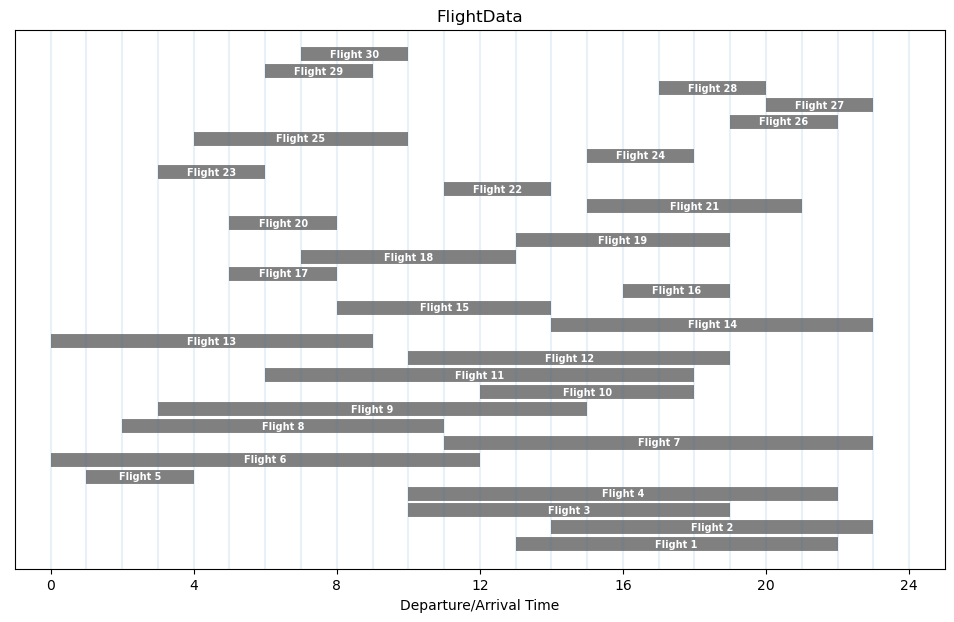

In [139]:
# visualize flight data
def draw_flights(FlightData):
    bar_style = {'alpha':1.0, 'lw':10, 'solid_capstyle':'butt'}
    text_style = {'fontsize': 7, 'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, xlabel="Departure/Arrival Time", title="FlightData")
    ax.get_yaxis().set_visible(False)
    for flight, row in FlightData.iterrows():
        departure, arrival = row
        ax.plot([departure, arrival], [flight]*2, 'gray', **bar_style)
        ax.text((departure + arrival)/2, flight, f"Flight {flight}", **text_style)
    for hr in range(25):
        ax.axvline(hr, alpha=0.1)
    ax.set_xlim(-1, 25)
    ax.set_xticks([4*i for i in range(7)])
    return ax

draw_flights(FlightData)

## Pyomo Model

The fleet assignment problem can be formulated and solved as an MILP. The idea of the MILP formulation is to construct feasible paths in a directed graph where the flights are nodes with indices $\mathcal{F} = \left\{ 1, \ldots, F \right\}$. The set of arcs $\mathcal{A} \subseteq \mathcal{F} \times \mathcal{F}$ that can be used by each aircraft is then:

$$
\mathcal{A} = \{ a = (f_1, f_2): f_1 \text{ arrives at least 1h before the departure of } f_2, \ f_1, f_2 \in \mathcal{F} \}
$$

The following cell finds the set of arcs that can be used. These arcs are displayed in a graph of the flight data. Arcs corresponding to the minimum time between arrival and departure are highlighted in red.

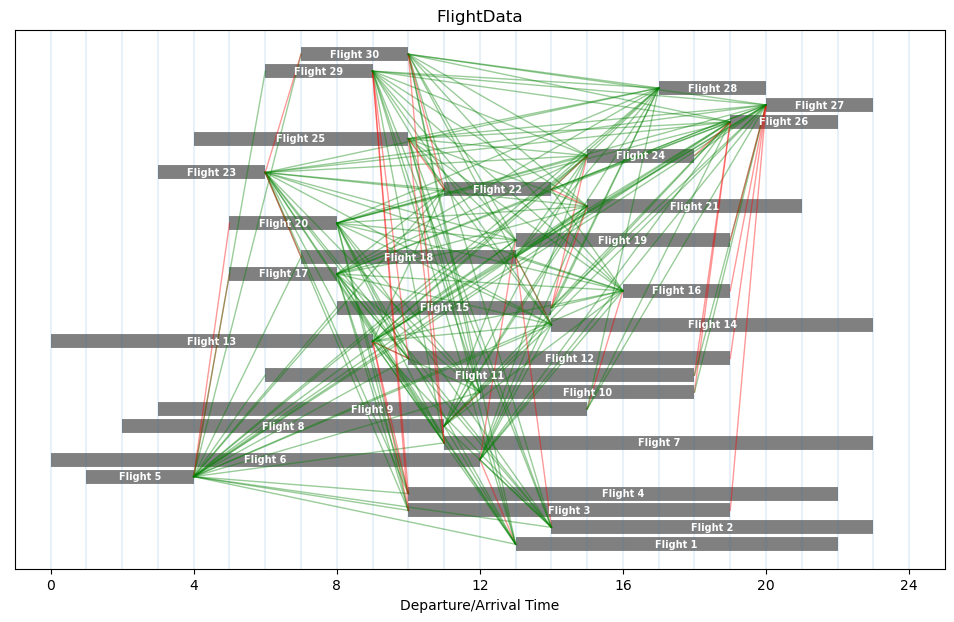

In [140]:
min_time = 1

def feasible_flight_pairs(FlightData, min_time=1):
    # return a dictionary of turnaound times index by flight pairs
    turnaround = lambda pair: FlightData.loc[pair[1], "Departure"] - FlightData.loc[pair[0], "Arrival"]
    pairs = filter(
        lambda pair: turnaround(pair) >= min_time,
        [(i, j) for i in FlightData.index for j in FlightData.index if i != j]
    )
    return {pair: turnaround(pair) for pair in pairs}
    
flight_pairs = feasible_flight_pairs(FlightData).keys()

ax = draw_flights(FlightData)
for flight1, flight2 in flight_pairs:
    arr = FlightData.loc[flight1, "Arrival"]
    dep = FlightData.loc[flight2, "Departure"]
    c = 'r' if dep - arr <= min_time else 'g'
    ax.plot([arr, dep], [flight1, flight2], color=c, lw=1, alpha=0.4)

The following cell presents another visualization of feasible paths in which an aircraft can be reassigned from one flight to another. Each node corresponds to a flight. An edge from flight $f_1$ to flight $f_2$ is included only if there is at least `min_time` hours available to `turn around` the aircraft. Edges are colored red to indicate edges that allow exactly `min_time` hours between flights since these will be the most affected by unexpected flight delays.

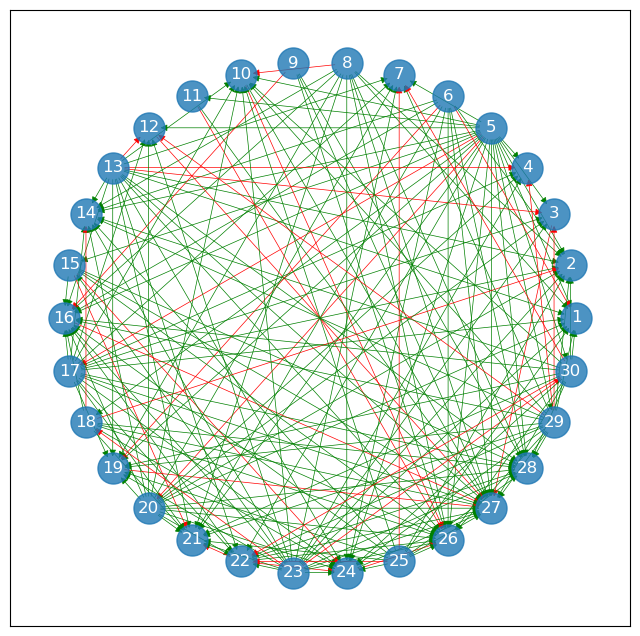

In [141]:
import networkx as nx

dg = nx.DiGraph()

for flight in FlightData.index:
    dg.add_node(flight)

for pair, dur in feasible_flight_pairs(FlightData).items():
    dg.add_edge(pair[0], pair[1], color = 'r' if dur <= min_time else 'g')
    
size = int(1.5 * np.sqrt(len(FlightData)))
fig = plt.figure(figsize=(size, size))
pos = nx.circular_layout(dg)
nx.draw_networkx_nodes(dg, pos=pos, node_size=500, alpha=0.8)
nx.draw_networkx_labels(dg, pos=pos, font_color = "w")
nx.draw_networkx_edges(dg, pos=pos, width=.5, edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges]);


For each node $f\in\mathcal{F}$ in the DiGraph we define a set of input nodes $\mathcal{I}_f = \{f_1: (f_1, f)\in\mathcal{A}\}$  and a set of output nodes $\mathcal{O}_f = \{f_1: (f, f_1)\in\mathcal{A} \}$. For this application, we use the Python ``set`` object to scan the feasible flight pairs and find the inputs and outputs nodes for each flight node. 

In [142]:
in_nodes = {flight: set() for flight in FlightData.index}
out_nodes = {flight: set() for flight in FlightData.index}

for flight1, flight2 in flight_pairs:
    in_nodes[flight2].add(flight1)
    out_nodes[flight1].add(flight2)

The decision variables are:

* $x_{f_1, f_2}\in\{0,1\}$ for all $(f_1, f_2) \in\mathcal{A}$ where $x_{f_1, f_2} = 1$ indicates that an aircraft used for arriving flight $f_1$ will used for departing flight $f_2$.

* $p_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $p_f = 1$ indicates a previously unassigned aircraft will be use for departing flight $f$.

* $q_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $q_f = 1$ indicates an aircraft will be unassigned after arrival of flight $f$.

The binary variables $p_f$ and $q_f$ correspond to arcs that link nodes to the sources and sinks of aircraft needed to complete all of the flights $f\in\mathcal{F}$. The objective is to minimize the number of required aircraft subject to the constraints that exactly one aircraft is a assigned to and released from each node.

$$\begin{align}
\min\limits_{x_a, p_f, q_f}\quad & \sum_{f\in\mathcal{F}} p_f \\
\text{s.t.}\quad & p_f + \sum_{f_1\in\mathcal{I}_f} x_{f_1, f} = 1 & \forall f\in\mathcal{F} \\
& q_f + \sum_{f_1\in\mathcal{O}_f} x_{f, f_1} = 1 & \forall f\in\mathcal{F}
\end{align}$$

In [143]:
m = pyo.ConcreteModel("Fleet Assignment")
  
m.FLIGHTS = pyo.Set(initialize=FlightData.index)
m.PAIRS = pyo.Set(initialize=flight_pairs)

m.x = pyo.Var(m.PAIRS, domain=pyo.Binary)
m.p = pyo.Var(m.FLIGHTS, domain=pyo.Binary)
m.q = pyo.Var(m.FLIGHTS, domain=pyo.Binary)

@m.Constraint(m.FLIGHTS)
def sources(m, flight):
    return m.p[flight] + sum(m.x[_, flight] for _ in in_nodes[flight]) == 1

@m.Constraint(m.FLIGHTS)
def sinks(m, flight): 
    return m.q[flight] + sum(m.x[flight, _] for _ in out_nodes[flight]) == 1

@m.Objective(sense=pyo.minimize)
def minimize_airplanes(m):
    return pyo.summation(m.p)

pyo.SolverFactory("cbc").solve(m)

print(f"Minimum airplanes required = {m.minimize_airplanes()}")

Minimum airplanes required = 14.0


We visualize the solution by redrawing the graph of possible path and highlighting the edges that have been selected for aircraft reassignment. 

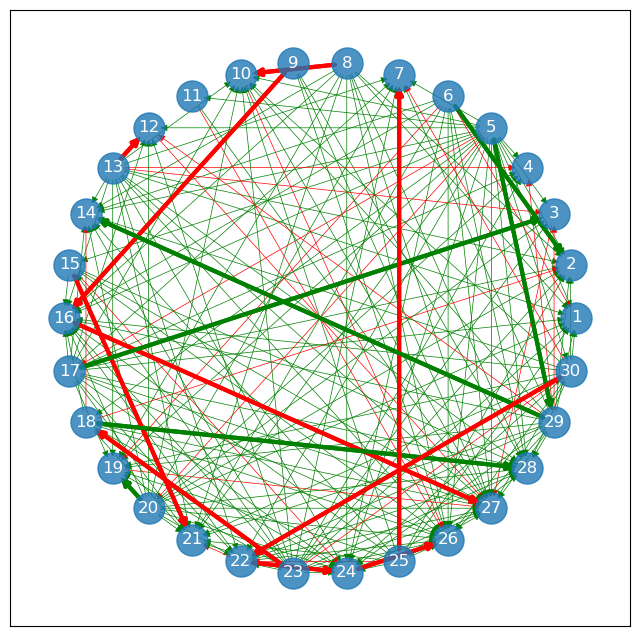

In [145]:
import networkx as nx

dg_soln = nx.DiGraph()

for flight in FlightData.index:
    dg_soln.add_node(flight)

for pair, dur in feasible_flight_pairs(FlightData).items():
    if m.x[pair[0], pair[1]].value == 1:
        dg_soln.add_edge(pair[0], pair[1], color = 'r' if dur <= min_time else 'g')
    
size = int(1.5 * np.sqrt(len(FlightData)))
fig = plt.figure(figsize=(size, size))

nx.draw_networkx_nodes(dg_soln, pos=pos, node_size=500, alpha=0.8)
nx.draw_networkx_labels(dg_soln, pos=pos, font_color = "w")
nx.draw_networkx_edges(dg_soln, pos=pos, width=3, edge_color=[dg_soln.edges[u, v]["color"] for u, v in dg_soln.edges]);
nx.draw_networkx_edges(dg, pos=pos, width=.5, edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges]);
nx.draw_networkx_edges(dg_soln, pos=pos, width=3, edge_color=[dg_soln.edges[u, v]["color"] for u, v in dg_soln.edges]);


We visualize the solution by drawing arcs where $x_{f_1, f_2} = 1$ and where $p_f = 1$ and $q_f = 1$. These arcs draw feasible paths through the graph corresponding to the assignment of one aircraft to service one or more flights.

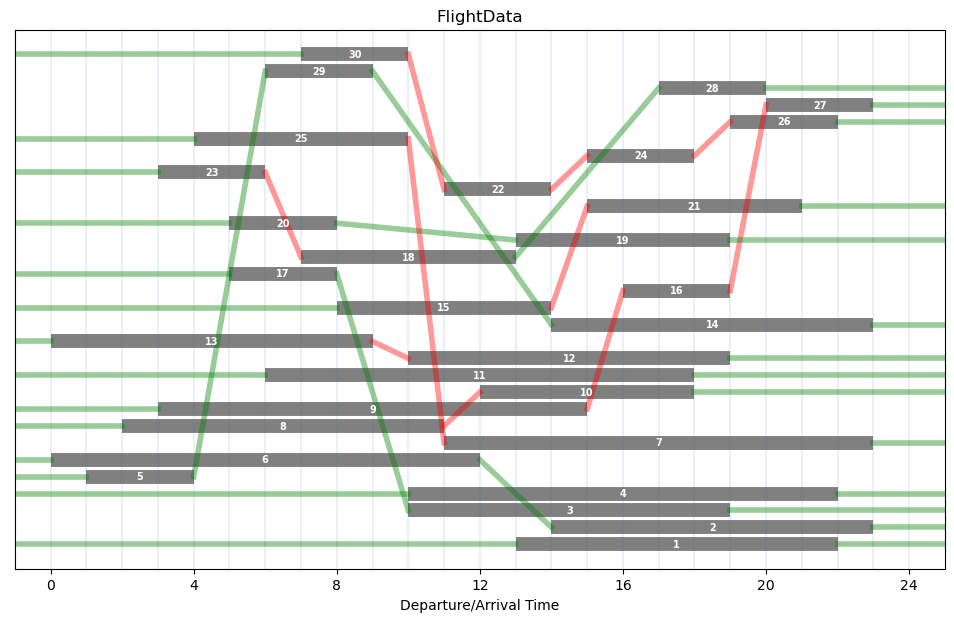

In [138]:
ax = draw_flights(FlightData)
for flight1, flight2 in flight_pairs:
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = 'r' if dep - arr <= min_time else 'g'
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight]*2, 'g', lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight]*2, 'g', lw=4, alpha=0.4)

## Create Flight and Aircraft Schedules

* **Flight Schedule**: A table index by flight numbers showing the assigned aircraft, departure, and arrival times.
* **Aircraft Schedule**: A table indexed by aircraft and flights showing departure and arrival times. 

In [29]:
FlightSchedule = FlightData.copy()

# create a generator of aircraft ids
aircraft = (f"A{n+1:02d}" for n in range(len(FlightData.index)))

# traverse each path through the graph
for f in FlightData.index:
    if m.p[f]() == 1:
        id = next(aircraft)
        FlightSchedule.loc[f, "Aircraft"] = id
        while m.q[f]() != 1:
            f = next(filter(lambda _: m.x[f, _]() == 1, out_nodes[f]))
            FlightSchedule.loc[f, "Aircraft"] = id
            
FlightSchedule = FlightSchedule[["Aircraft", "Departure", "Arrival"]]
display(FlightSchedule)

,Aircraft,Departure,Arrival
Flight,,,
1,A01,13,22
2,A04,14,23
3,A10,10,19
4,A02,10,22
5,A03,1,4
6,A04,0,12
7,A13,11,23
8,A05,2,11
9,A06,3,15


In [30]:
AircraftSchedule = FlightSchedule.copy()
AircraftSchedule["Flight"] = AircraftSchedule.index
AircraftSchedule = AircraftSchedule.sort_values(["Aircraft", "Departure"])
AircraftSchedule.index = pd.MultiIndex.from_frame(AircraftSchedule[["Aircraft", "Flight"]])
AircraftSchedule = AircraftSchedule[["Departure", "Arrival"]]
display(AircraftSchedule)

Departure  Arrival
Aircraft Flight                    
A01      1              13       22
A02      4              10       22
A03      5               1        4
         29              6        9
         14             14       23
A04      6               0       12
         2              14       23
A05      8               2       11
         10             12       18
A06      9               3       15
         16             16       19
         27             20       23
A07      11              6       18
A08      13              0        9
         12             10       19
A09      15              8       14
         21             15       21
A10      17              5        8
         3              10       19
A11      20              5        8
         19             13       19
A12      23              3        6
         18              7       13
         28             17       20
A13      25              4       10
         7              11       23
A14      30              7       10
         22             11       14
         24             15       18
         26             19       22

## Reducing riskiness of the schedule

We will now to keep the maximum number of flights at the optimal level, but try to minimize their riskiness. To do so, we define a slightly different MILP that takes the minimum number of planes `nplanes` in input and has the total number of risky pairs as objective function.


In [31]:
def schedule(FlightData, N_planes, min_time=1):
    
    pairs = feasible_flight_pairs(FlightData, min_time)
    
    weights = {pair: int(pairs[pair] == min_time) for pair in pairs}
    
    in_nodes = {flight: set() for flight in FlightData.index}
    out_nodes = {flight: set() for flight in FlightData.index}

    for flight1, flight2 in pairs.keys():
        in_nodes[flight2].add(flight1)
        out_nodes[flight1].add(flight2)

    m = pyo.ConcreteModel("Fleet Assignment")

    m.FLIGHTS = pyo.Set(initialize=FlightData.index)
    m.PAIRS = pyo.Set(initialize=pairs.keys())

    m.x = pyo.Var(m.PAIRS, domain=pyo.Binary)
    m.p = pyo.Var(m.FLIGHTS, domain=pyo.Binary)
    m.q = pyo.Var(m.FLIGHTS, domain=pyo.Binary)

    @m.Constraint(m.FLIGHTS)
    def sources(m, flight):
        return m.p[flight] + sum(m.x[_, flight] for _ in in_nodes[flight]) == 1

    @m.Constraint(m.FLIGHTS)
    def sinks(m, flight): 
        return m.q[flight] + sum(m.x[flight, _] for _ in out_nodes[flight]) == 1

    @m.Constraint()
    def minimize_airplanes(m):
        return pyo.summation(m.p) <= N_planes

    @m.Objective(sense=pyo.minimize)
    def minimize_risk(m):
        return sum(m.x[pair] * weights[pair] for pair in m.PAIRS)

    pyo.SolverFactory("cbc").solve(m)
    
    ax = draw_flights(FlightData)
    for flight1, flight2 in pairs.keys():
        if m.x[flight1, flight2]() == 1:
            arr = FlightData.loc[flight1, "Arrival"]
            dep = FlightData.loc[flight2, "Departure"]
            c = 'r' if dep - arr <= min_time else 'g'
            ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

    for flight in FlightData.index:
        if m.p[flight]() == 1:
            dep = FlightData.loc[flight, "Departure"]
            ax.plot([-1, dep], [flight]*2, 'g', lw=4, alpha=0.4)
        if m.q[flight]() == 1:
            arr = FlightData.loc[flight, "Arrival"]
            ax.plot([arr, 25], [flight]*2, 'g', lw=4, alpha=0.4)
            
    return m

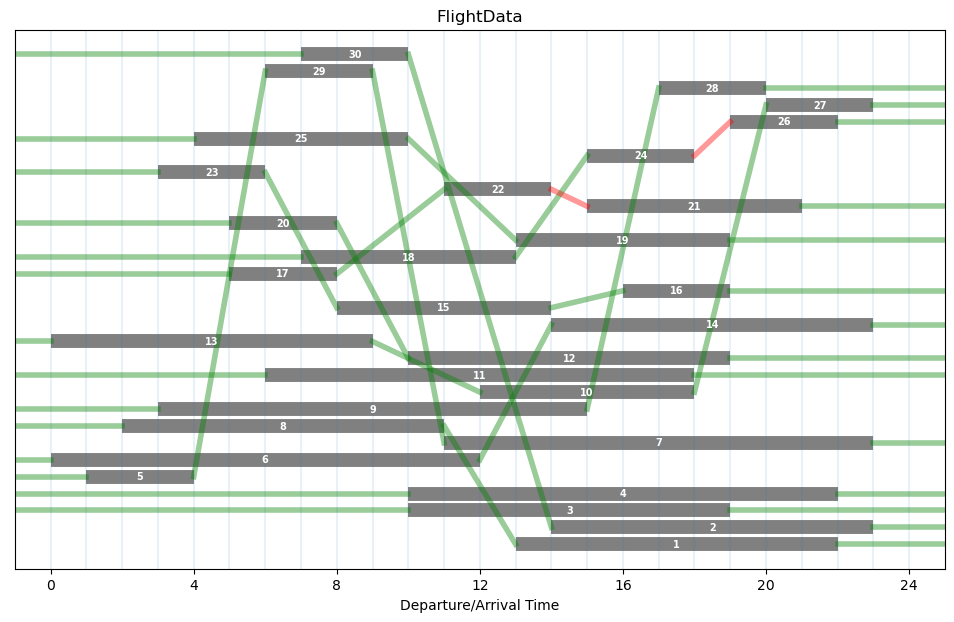

In [11]:
m = schedule(FlightData, N_planes=14, min_time=1)

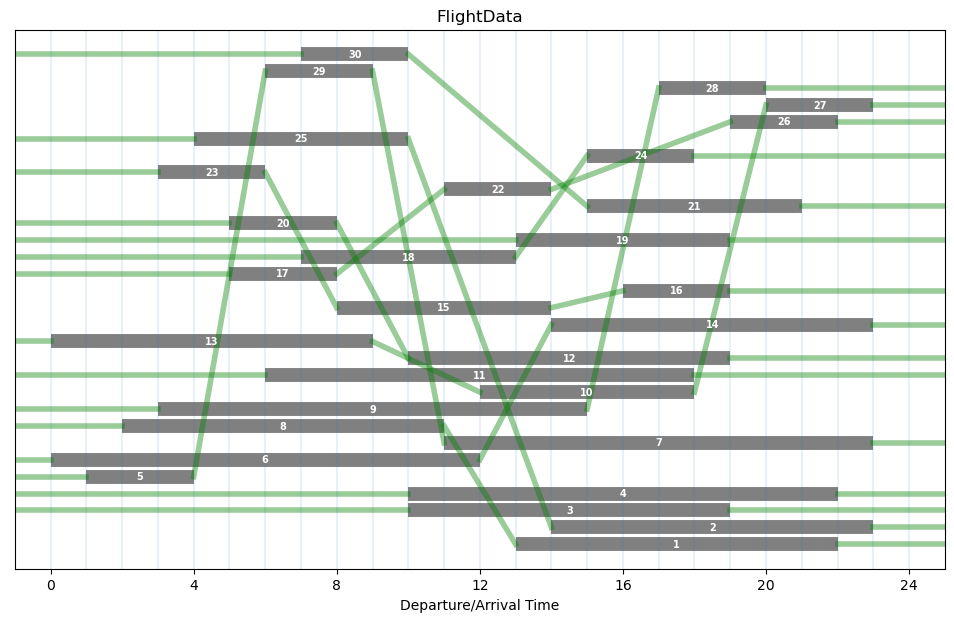

In [16]:
m = schedule(FlightData, N_planes=15, min_time=1)

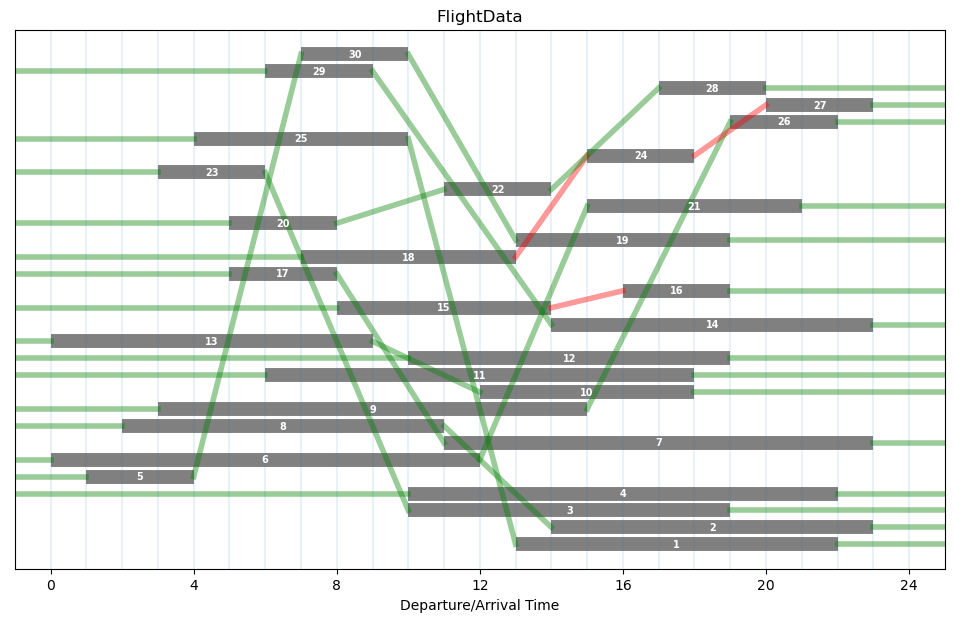

In [17]:
m = schedule(FlightData, N_planes=15, min_time=2)